
## **Adopter Prediction Challenge**

 ~ Ankita, Ashok, Kaydee, Young
 
 ---

Website XYZ, a music-listening social networking website, follows the “freemium” business model. The website offers basic services for free, and provides a number of additional premium capabilities for a monthly subscription fee. We are interested in predicting which people would be likely to convert from free users to premium subscribers in the next 6 month period, if they are targeted by our promotional campaign.

### Dataset

We have a dataset from the previous marketing campaign which targeted a number of non-subscribers.

Features: 

```
1.   adopter (predictor class)
2.   user_id
3.   age
4.   male
5.   friend_cnt
6.   avg_friend_age
7.   avg_friend_male
8.   friend_country_cnt
9.   subscriber_friend_cnt
10.   songsListened
11.   lovedTracks
12.   posts
13.   playlists
14.   shouts
15.   good_country
16.   tenure
17.   *other delta variables*
```



### Task

The task is to build the best predictive model for the next marketing campaign, i.e., for predicting likely `adopters` (that is, which current non- subscribers are likely to respond to the marketing campaign and sign up for the premium service within 6 months after the campaign).

---

### EDA

Performing some rudimentary EDA

In [0]:
!pip3 install sklearn

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from google.colab import drive
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, classification_report, recall_score, f1_score

from imblearn.over_sampling import SMOTE

In [0]:
# drive.mount('/content/drive/')

# original dataset
data = pd.read_csv('https://drive.google.com/uc?export=view&id=1wctM0dYDj839zp6sTlFnDgCmFspXhDuW')

# rose_data from the R script
# data = pd.read_csv('https://drive.google.com/uc?export=view&id=14wilOFigXttteZAt5oUHT9fh1m5LhnJj')

data.adopter.value_counts()

0    85142
1     1540
Name: adopter, dtype: int64

In [0]:
imp_features = fetch_feature_importance(pca_df, pca.components_, data.columns.values)

pca_features = []

for item in imp_features:
  pca_features.append(item[1])
  
top_pca_features = pca_features[0:13]

# fetching top 12 features from the dataset
X = data[top_pca_features]
X = X.drop(['user_id'], axis = 1)
y = data.iloc[:, data.columns == 'adopter']

In [0]:
# splitting original dataset into features and predictor
X = data.iloc[:, data.columns != 'adopter']
y = data.iloc[:, data.columns == 'adopter']

# splitting the original dataset for cross-validation (0.7 train, 0.3 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print ("Original Data:")
print ("Number of train instances: {}".format(len(X_train)))
print ("Number of test instances: {}".format(len(X_test)))

Original Data:
Number of train instances: 60677
Number of test instances: 26005


## SMOTE splitting

We'll use SMOTE (Synthetic Minority Oversampling Technique) to create(synthesize) more samples of minority class. The recall score we got earlier might be less as we imputed more than 80% of the data to balance the dataset. 

Before we SMOTE the entire dataset, synthesizing around 58000 new instances of minority will not introduce enough variation in data for the models to learn. 

We decide that we will include only a subset of the majority class instances (4000) and synthsize 4000-1540=2460 new instances for minority class using SMOTE. That'll avoid our models from overfitting. 

In [0]:
# fetching the indices of minority instances
adopting_indices = np.array(data[data.adopter == 1].index)

# fetching indices of normal instances
non_adopting_indices = data[data.adopter == 0].index

# randomly select 1540 normal instances to create a 50/50 partitioned balanced dataset
random_non_adopting_indices = np.random.choice(non_adopting_indices,
                                            10000,
                                            replace = False)
random_non_adopting_indices = np.array(random_non_adopting_indices)

# combining both the instance groups (minority and the new random set) 
undersampled_indices = np.concatenate([adopting_indices, random_non_adopting_indices])

# creating the undersampled dataset
undersampled_data = data.iloc[undersampled_indices, :]

# storing the features(X) and predictor class(y)
X_undersample = undersampled_data.iloc[:, undersampled_data.columns != 'adopter']
y_undersample = undersampled_data.iloc[:, undersampled_data.columns == 'adopter']

print("Number of minority instances: {}\nNumber of normal instances: {} \nTotal: {}".format(len(undersampled_data[undersampled_data.adopter == 1]), 
                                                                                           len(undersampled_data[undersampled_data.adopter == 0]),
                                                                                           len(undersampled_data)))

Number of minority instances: 1540
Number of normal instances: 10000 
Total: 11540


In [0]:
# splitting original dataset into features and predictor
X = undersampled_data.iloc[:, data.columns != 'adopter']
y = undersampled_data.iloc[:, data.columns == 'adopter']

# splitting the original dataset for cross-validation (0.7 train, 0.3 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print ("Undersampled Data:")
print ("Number of train instances: {}".format(len(X_train)))
print ("Number of test instances: {}".format(len(X_test)))

Undersampled Data:
Number of train instances: 8078
Number of test instances: 3462


In [0]:
sm = SMOTE(random_state = 12, ratio = None)
X_train_smoted_np, y_train_smoted_np = sm.fit_sample(X_train, y_train)
# X_train_smoted, y_train_smoted = sm.fit_sample(X_train, y_train.values.ravel())
print(type(X_train_smoted_np))

<class 'numpy.ndarray'>


In [0]:
# checking the lengths of new training set
print ("Number of SMOTEd features: {}".format(len(X_train_smoted_np)))
print ("Number of SMOTEd predictors: {}".format(len(y_train_smoted_np)))
# print (y_train_smoted)
X_train.head()
y_train_smoted_non_adopters = y_train_smoted_np[y_train_smoted_np == 1]
y_train_smoted_adopters = y_train_smoted_np[y_train_smoted_np == 0]
# print (y_train_smoted_adopters)
# print (y_train_smoted_non_adopters)
# print ("Number of SMOTEd training features: {}".format(len(y_train_smoted[y_train_smoted.adopter == 0])))
print ("Number of SMOTEd non-adopters (adopter = 0): {}".format(len(y_train_smoted_non_adopters)))
print ("Number of SMOTEd adopters (adopter = 1): {}".format(len(y_train_smoted_adopters)))

Number of SMOTEd features: 6996
Number of SMOTEd predictors: 6996
Number of SMOTEd non-adopters (adopter = 0): 3498
Number of SMOTEd adopters (adopter = 1): 3498


We now have around 2792 instances each of both the classes, which is better than simple undersampling and having only 3080 instances in all.



In [0]:
#print(type(X_train_smoted_np))
X_train_smoted_np.view()

array([[6.68850000e+05, 2.60000000e+01, 0.00000000e+00, ...,
        1.50000000e+01, 0.00000000e+00, 0.00000000e+00],
       [6.89420000e+04, 2.30000000e+01, 0.00000000e+00, ...,
        4.70000000e+01, 0.00000000e+00, 0.00000000e+00],
       [1.48614400e+06, 2.20000000e+01, 1.00000000e+00, ...,
        5.70000000e+01, 1.00000000e+00, 0.00000000e+00],
       ...,
       [1.64551094e+06, 2.96783558e+01, 0.00000000e+00, ...,
        2.06420809e+01, 5.35671162e-01, 0.00000000e+00],
       [1.23352298e+06, 2.82531574e+01, 2.48947524e-01, ...,
        6.14852653e+01, 7.51052476e-01, 0.00000000e+00],
       [1.49676892e+06, 2.01448351e+01, 6.04775978e-02, ...,
        9.78196950e+00, 1.00000000e+00, 0.00000000e+00]])

In [0]:
#TODO: Convert the train sets to dataframes from ndarray and recaluclate the recalls
X_train_smoted = pd.DataFrame(data = X_train_smoted_np[:, :],
                             index = X_train_smoted_np[:, ],
                             columns = X_train_smoted_np[,:])
print(type(X_train_smoted))

SyntaxError: ignored

For now we'll import smoted data from our R scripts since the above is taking time.

In [0]:
rose_data = pd.read_csv('https://drive.google.com/uc?export=view&id=14wilOFigXttteZAt5oUHT9fh1m5LhnJj')
#data = rose_data

## Splitting data and shoving training data into a log regressor

In [0]:
# splitting original dataset into features and predictor
X = data.iloc[:, data.columns != 'adopter']
y = data.iloc[:, data.columns == 'adopter']

# splitting the original dataset for cross-validation (0.7 train, 0.3 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print ("Original Data:")
print ("Number of train instances: {}".format(len(X_train)))
print ("Number of test instances: {}".format(len(X_test)))
print ("X_train type: {}".format(type(X_train)))

y.adopter.value_counts()

Original Data:
Number of train instances: 60677
Number of test instances: 26005
X_train type: <class 'pandas.core.frame.DataFrame'>


1    43393
0    43289
Name: adopter, dtype: int64

Before we build the model to test our data on, we need to fix on the C - parameter. We will consider recall as the metric to iterate over different C-param value and chose the best C-param that gives the best recall rate. 

more on C-param here: https://stackoverflow.com/questions/22851316/what-is-the-inverse-of-regularization-strength-in-logistic-regression-how-shoul 

In [0]:
# function to loop over different C-param values and choose the one with best recall score
c_params = [0.01, 0.1, 1, 10, 100, 1000]

def mean_recalls_with_c_params(X_train, y_train):
  
  '''
  Trains a regressor with KFold for multiple C parameter values and returns the C-param for the regressor with best recall
  '''
  
  # getting the different fold for KFold
  fold = KFold(n_splits=5, random_state=None, shuffle=False)
  
  # storing mean recall rates in a dataframe
  recall_results = pd.DataFrame(index = range(len(c_params), 2),
                               columns = ['C-param value', 'Mean recall score'])
  recall_results['C-param values'] = c_params
  
  temp = 0
  for c_param in c_params:

    print ("C = {}\n ----------".format(c_param))
    recall_scores = []
    
    # building a model on each fold
    # since we have a lot of features, we'll use l1 regularisation instead of l2
    for iteration, indices in enumerate(fold.split(X_train), start = 1):
      log_regressor = LogisticRegression(C = c_param,
                                        penalty = 'l1')
      # indices[0] contain the train data indices for the current fold
      log_regressor.fit(X_train.iloc[indices[0], :],
            y_train.iloc[indices[0], :].values.ravel())
      
      # indices[1] contain teh test data
      y_pred = log_regressor.predict(X_train.iloc[indices[1], :].values)
      
      # calculate the recall scores and store in recall_rates
      recall_score_current = recall_score(y_train.iloc[indices[1], :].values,
                                         y_pred)
      recall_scores.append(recall_score_current)
      
      print ("Iteration {} has recall score: {}".format(iteration, recall_score_current))
      
    # storing the mean recall score after each fold
    recall_results.ix[temp, 'Mean recall score'] = np.mean(recall_scores)
    temp += 1
    print ('Mean recall for C = {}: {}'.format(c_param, np.mean(recall_scores)))
    
  # fetching the best C-param 
  c_param_optimal = recall_results.loc[recall_results['Mean recall score'].astype('float64').idxmax()]['C-param value']
  print ("Best C-param: {}".format(c_param_optimal))
  return c_param_optimal  

In [0]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

c_optimal = mean_recalls_with_c_params(X_train_smoted_np, y_train_smoted_np)

C = 0.01
 ----------


AttributeError: ignored

In [0]:
# temp function to plot confusion matrix

def plot_conf_matrix(cm, 
                     classes,
                     normalize=False,
                     title='Confusion matrix',
                     cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the testing dataset: 0.5855855855855856
Precision metric in the testing dataset: 0.2658486707566462
f-score on the test dataset: 0.3656821378340365
0.3656821378340365


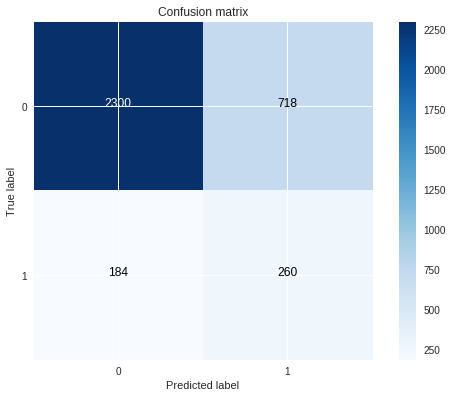

In [0]:
lr = LogisticRegression(C = 100, penalty = 'l1')
lr.fit(X_train_smoted_np,y_train_smoted_np)
y_pred_smoted = lr.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_smoted, labels=[0,1])
np.set_printoptions(precision=2)

recall_val = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
precision_val = cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1])
f1_score_val = 2*((recall_val*precision_val)/(recall_val+precision_val))

print("Recall metric in the testing dataset: {}".format(recall_val) )
print("Precision metric in the testing dataset: {}".format(precision_val))
print("f-score on the test dataset: {}".format(f1_score_val) )
f1_temp = f1_score(y_test, y_pred_smoted)
print(f1_temp)

class_names = [0,1]
plt.figure()
plot_conf_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()